Suppose each sample point $X_i$ consists of a pair $X_i = (Y_i, Z_i)$. The variance-stabilized correlation coefficient is
\begin{equation}
    T(X) = \frac{1}{2} \log\left(\frac{1 + r(X)}{1 - r(X)}\right),
\end{equation}
where
\begin{equation}
    r(X) = \frac{\sum_{i=1}^n(Y_i - \bar{Y})(Z_i - \bar{Z})}{\sqrt{\sum_{i=1}^n(Y_i - \bar{Y})^2} \sqrt{\sum_{i=1}^n(Z_i - \bar{Z})^2}},
\end{equation}
and $\bar{Y} = n^{-1}\sum Y_i$ and $\bar{Z} = n^{-1}\sum Z_i$.

In [1]:
# @title Data
csv_data = """
VIQ,PIQ
6,6.333
7,9.333
7.5,6.333
8.5,10.333
8.5,12.333
9,7
9,8.667
9,9.333
9,10.667
9.5,8
9.5,8.333
9.5,8.667
9.5,10
9.5,10.667
10,6.667
10,9
10,9.667
10,9.667
10,10
10,10
10,10.667
10,12
10,12.333
10.5,7.667
10.5,8.333
10.5,9
10.5,9
10.5,10
10.5,10
10.5,10.667
10.5,12
11,9.667
11,10
11,10
11,10.667
11,10.667
11,10.667
11,12.333
11,12.333
11,13.333
11.5,6.667
11.5,7.333
11.5,7.667
11.5,7.667
11.5,8
11.5,8.333
11.5,9
11.5,9
11.5,9.333
11.5,10
11.5,10
11.5,10
11.5,10
11.5,10.333
11.5,11
11.5,11.333
11.5,11.667
11.5,12
11.5,12.333
11.5,14.667
11.5,15
12,8.333
12,9
12,9
12,9
12,9
12,10.333
12,10.333
12,10.667
12,10.667
12,10.667
12,11.667
12,13.333
12,13.333
12.5,7.333
12.5,9
12.5,9
12.5,9.333
12.5,10
12.5,10.333
12.5,10.333
12.5,10.667
12.5,11.333
12.5,12
12.5,13.333
12.5,14
12.5,14
13,9.333
13,9.333
13,9.667
13,10
13,10.333
13,10.333
13,10.333
13,10.667
13,11.333
13,11.667
13,12
13,13
13,13
13,13.667
13,14
13,15.333
13.5,10
13.5,12.333
13.5,12.667
13.5,14
13.5,14.667
14,10.667
14,11.333
14,15.667
14,16
14,17.333
14.5,14.333
14.5,16.667
15,11.333
15,11.667
15.5,10.667
15.5,11
16,11.667
"""

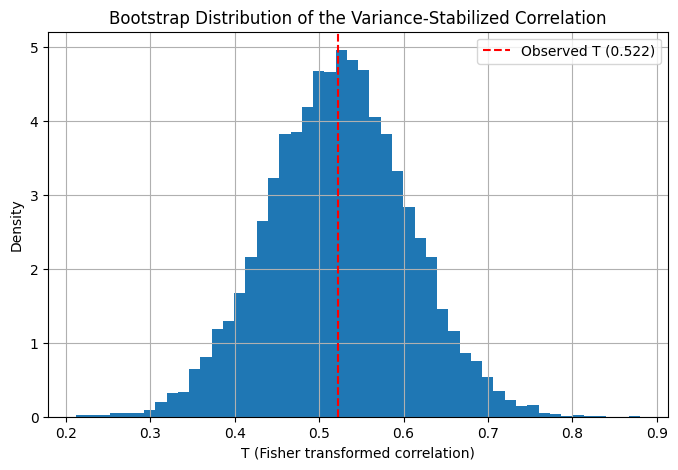

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

df = pd.read_csv(io.StringIO(csv_data.strip()))
n = len(df)

def calculate_T(data):
    # Pearson correlation coefficient r
    r = data['VIQ'].corr(data['PIQ'])
    # Fisher transformation: T = 0.5 * log((1+r)/(1-r))
    return 0.5 * np.log((1 + r) / (1 - r))

def bootstrap_T(data, B):
    T_values = []
    for _ in range(B):
        resample = data.sample(n=n, replace=True)
        T_b = calculate_T(resample)
        T_values.append(T_b)
    return T_values

def plot_histogram(data, T, title):
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=50, density=True)
    plt.axvline(T, color='red', linestyle='--', label=f'Observed T ({T:.3f})')
    plt.title(title)
    plt.xlabel('T (Fisher transformed correlation)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

T_observed = calculate_T(df)
bootstrap_T_values = bootstrap_T(df, 10000)
plot_histogram(bootstrap_T_values, T_observed, 'Bootstrap Distribution of the Variance-Stabilized Correlation')

One of the primary reasons for using the variance-stabilized transformation $T$ (the Fisher transformation) is that it transforms the skewed sampling distribution of the raw correlation $r$ into a distribution that is approximately normal. The raw correlation is bounded by $[-1, 1]$ and is often skewed. The distribution is centred close to the observed $T$ which indicates little bias. The width of the histogram represents the standard error of $T$ which theoretically should be approximately $1/(n-3)$.

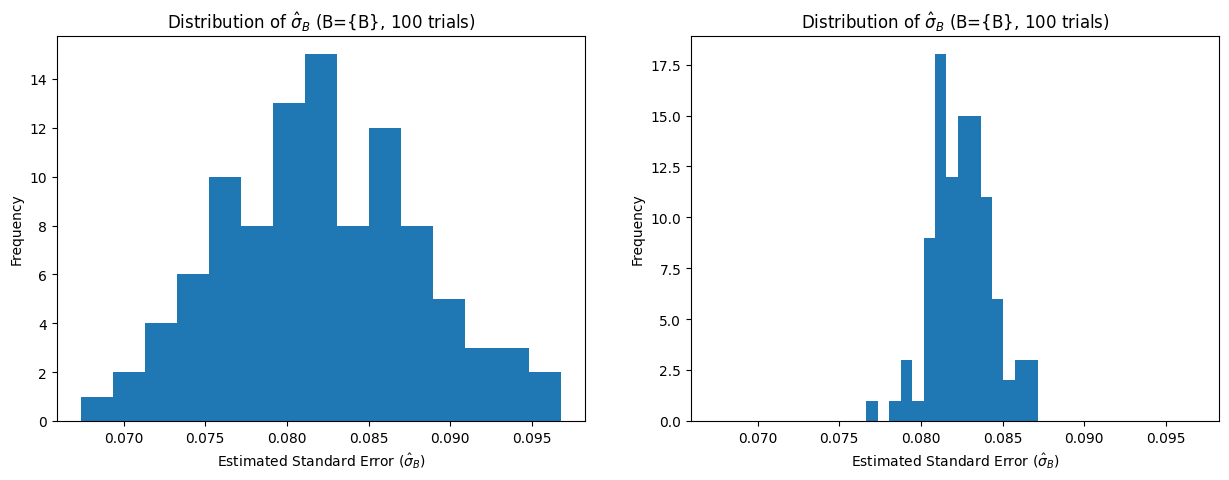

In [15]:
def get_bootstrap_se(data, B):
    '''
    Calculates one instance of sigma_hat_B.
    '''
    boot_T = []
    for _ in range(B):
        resample = data.sample(n=len(data), replace=True)
        boot_T.append(calculate_T(resample))
    return np.std(boot_T, ddof=1)

num_experiments = 100
B_values = [100, 1000]

results = {}
for B in B_values:
    results[B] = [get_bootstrap_se(df, B) for _ in range(num_experiments)]

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
for i, B in enumerate(B_values):
    axes[i].hist(results[B], bins=15)
    axes[i].set_title(r"Distribution of $\hat{{\sigma}}_B$ (B={B}, 100 trials)")
    axes[i].set_xlabel(r"Estimated Standard Error ($\hat{\sigma}_B$)")
    axes[i].set_ylabel(r"Frequency")

plt.show()

As $B$ increases, the histogram of $\hat{\sigma}_B$ becomes narrower and more concentrated. For lower $B$, the estimate of the standard error is quite noisy due to simulation randomness. For higher $B$, the estimate becomes much more clustered around a single value, the true bootstrap estimate.

*   For standard errors, Efron originally suggested that $B \in [50, 200]$ is usually sufficient to get a stable estimate of a standard error, since the Monte Carlo error decreases at a rate of $1/\sqrt{B}$.
*   For confidence intervals, if we were using the bootstrap to find $95\%$ confidence intervals, we would need a much higher value of $B \geq 1000$, because the tails of a distribution are harder to estimate than its spread.
standard deviations from the bootstrap mean."

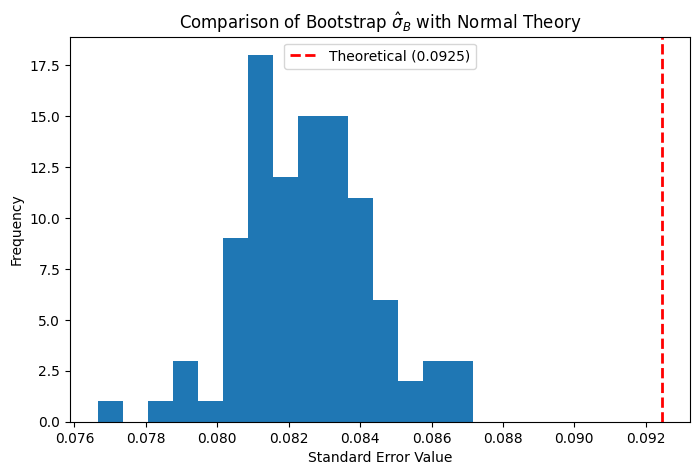

Bootstrap Mean SE: 0.08250
The theoretical value is 5.42 standard deviations from the bootstrap mean.


In [16]:
theoretical_se = 1 / np.sqrt(n - 3)
plt.figure(figsize=(8, 5))
plt.hist(results[1000], bins=15)
plt.axvline(theoretical_se, color='red', linestyle='--', linewidth=2, label=f'Theoretical ({theoretical_se:.4f})')
plt.title(r"Comparison of Bootstrap $\hat{\sigma}_B$ with Normal Theory")
plt.xlabel("Standard Error Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()
boot_mean_se = np.mean(results[1000])
boot_std_se = np.std(results[1000])
z_score = (theoretical_se - boot_mean_se) / boot_std_se
print(f"Bootstrap Mean SE: {boot_mean_se:.5f}")
print(f"The theoretical value is {abs(z_score):.2f} standard deviations from the bootstrap mean.")

The theoretical value is far in the tails, more than $5$ standard deviations away. This is evidence against the hypothesis. It suggests that the variability of the correlation in the data is significantly different from what would be expected if the data were purely bivariate normal.

The Fisher transformation is specifically designed to normalise the correlation coefficient. We can see that the histogram is quite symmetric so there is not strong evidence to suggest that the underlying VIQ/PIQ data is not bivariate normal.